## Map of US Colleges

In this notebook, I will cluster the colleges with doctoral degree programs based on some academic criteria and locate them on the map.

### 1. Import required libraries

__Folium__ is a Python wrapper for Leaflet.js just as suggested by its name. It is used for visualizing geospatial data. "It has the power of Leaflet. Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. Manipulate your data in Python, then visualize it in a Leaflet map via folium." (https://github.com/python-visualization/folium)

"__GeoPandas__ is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and matplotlib for plotting." (https://geopandas.org/en/stable/)

Installing __GeoPandas__ could be problematic. I would suggest read these links first.
(https://geopandas.org/en/stable/getting_started/install.html,
https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b)

In [1]:
from platform import python_version
print(python_version())

3.10.8


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return False
}

<IPython.core.display.Javascript object>

In [3]:
import os
import re
import geopandas
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from IPython.display import display, HTML
%matplotlib inline

### 2. Data 

College data were downloaded from the website of the National Center for Education Statistics (NCES) (https://nces.ed.gov/ipeds/datacenter/Data.aspx). I selected a few features mostly related to academic performance. I also downloaded the data from the College Scorecard (https://collegescorecard.ed.gov/data/) mainly to obtain the geographic information of colleges. The data were updated on 2022-11-20.

The downloded data are located within the _Data_ folder.

__NCES data__: This work focuses on colleges that offer doctoral degrees. I filtered the data to keep only 786 colleges of such type and columns of some academic features.

In [4]:
data_colleges = pd.read_csv('Data/Data_1120-2022.csv') 
data_colleges = data_colleges[data_colleges["Doctor's degree-research/scholarship - programs offered (C2021DEP  Grand total)"] > 0]
mycols = ['UnitID',
 'Institution Name',
 'Percent admitted - total (DRVADM2021)', 'Admissions yield - total (DRVADM2021)',
 'Percent admitted - men (DRVADM2021)',
 'Percent admitted - women (DRVADM2021)',
 'Admissions yield - men (DRVADM2021)',
 'Admissions yield - women (DRVADM2021)',
 'Student-to-faculty ratio (EF2020D)',
 'Graduation rate - Bachelor degree within 4 years  total (DRVGR2021)',
 'SAT Critical Reading 75th percentile score (ADM2015_RV)',
 'SAT Math 75th percentile score (ADM2015_RV)',
 'State abbreviation (HD2021)'
]
          
data_colleges = data_colleges[mycols]

__Scorecard data:__ The original dataset contains rich information; I have reduced the data to contain only the geographical information of colleges for mapping.

In [5]:
data_info = pd.read_csv('Data/Scorecard_1120-2022.csv',low_memory=False)

__Merged data__: Merge the two datasets. Seven features were used to cluster the colleges. Here I chose them based on my personal belief that they are the most important data to assess the undergraduate academic competitviness of a college. For example, I think the 75th percentile scores are more relevant than the 25th one, though I do not have data to support it.

In [6]:
data_merged = data_info.merge(data_colleges, left_on='UNITID', right_on='UnitID')

data_merged.rename(columns={'UNITID': "ID",
                  'Institution Name': 'Name',
                  'State abbreviation (HD2021)': 'STATE'}, inplace=True)
data_merged.index = data_merged['ID'].tolist()

mycols2clust = [
 'Percent admitted - men (DRVADM2021)',
 'Percent admitted - women (DRVADM2021)',
 'Admissions yield - men (DRVADM2021)',
 'Admissions yield - women (DRVADM2021)',
 'Graduation rate - Bachelor degree within 4 years  total (DRVGR2021)',
 'SAT Critical Reading 75th percentile score (ADM2015_RV)',
 'SAT Math 75th percentile score (ADM2015_RV)']
data_cluster = data_merged[mycols2clust]

### 3. Clustering

I grouped the colleges based on the above selected features. I then used K-Means, one of the most popular unsupervided clustering approaches, for which I arbitrarily assiged the number of groups. There are ways to evaluate the optimal number, but here I chose to split them into 5 groups.

__imputation__: There were some missing values in the data. To keep all colleges and features, I decided to impute the missing data using the K-Nearest Neighbors (KNN) method, i.e., to infer a value based on its K neighboring observations.

In [7]:
missing_cols = data_cluster.columns[data_cluster.isnull().sum()>0]

if (len(missing_cols)>0):
    #print (len(missing_cols))
    from sklearn.neighbors import KNeighborsClassifier as KNN
    from sklearn.impute import KNNImputer
    data_cluster_imputed = pd.DataFrame(KNNImputer(n_neighbors = 5).fit_transform(data_cluster))

__Standardization__: The value scales of these features are very different. To avoid one feature dominating the influence of the model, I standardized the data, making them in identical or similar scale.

In [8]:
scaler = StandardScaler()
scaler = scaler.fit(data_cluster_imputed)
data_cluster_scaled = scaler.transform(data_cluster_imputed)

__K-Means clustering:__ Clustered the colleges using K-Means (K=5). The predcited groups of 1 to 5 were added to the original data. 

In [9]:
K = 5
d2mod = data_cluster_scaled

# Fit K-Means
mykm = KMeans(n_clusters=K, random_state= 1000)
mykm_pred = mykm.fit_predict(d2mod)
# Predicted values are 0-based
data_merged['Group'] = mykm_pred + 1

__Result summary__: Group 4 contains some most prestigious colleges including Ivy League, and Group 2 contains some fairly good college, mainly public schools.

In [10]:
names = data_merged['Name'].tolist()

nrows2display = max(Counter(mykm_pred).values())
name_list = {}

for k in range(K):
    nms = sorted([names[i] for i in np.where(mykm_pred==k)[0]])
    name_list[f'Group{k+1} ({len(nms)})'] = nms[:min(len(nms), nrows2display)] + ['.']* (nrows2display-len(nms))
    
name_df = pd.DataFrame(name_list, index=range(1, list(map(len, name_list.values()))[0]+1))


pd.set_option("display.max_rows", None)

display(HTML("<div style='height: 300px; overflow: auto; width: fit-content'>" + name_df.style.to_html() + "</div>"))


,Group1 (411),Group2 (90),Group3 (52),Group4 (47),Group5 (182)
1,A T Still University of Health Sciences,American University,Albizu University-Miami,Boston College,Adams State University
2,AOMA Graduate School of Integrative Medicine,Amridge University,Allen College,Boston University,Alabama A & M University
3,Abilene Christian University,Anderson University,Arizona State University Digital Immersion,Brown University,Alabama State University
4,Abraham Lincoln University,Bard College,Ashford University,California Institute of Technology,Alliant International University-San Diego
5,Academy of Chinese Culture and Health Sciences,Baylor University,Baker College,California Intercontinental University,Alvernia University
6,Adelphi University,Bentley University,Beis Medrash Heichal Dovid,Carnegie Mellon University,American InterContinental University
7,Adler University,Binghamton University,Bellin College,Columbia University in the City of New York,American International College
8,Air Force Institute of Technology-Graduate School of Engineering & Management,Biola University,Brigham Young University,Cornell University,American Public University System
9,Albany Medical College,Brandeis University,Bryan College of Health Sciences,Dartmouth College,Arkansas State University
10,Albert Einstein College of Medicine,Bryn Mawr College,California Miramar University,Duke University,Auburn University at Montgomery


__Visualization:__ Then I visualized a couple of features to have a clue of the difference between groups. I used SAT Math score, total admission rate, and total yield rate for comparison.

It was observable that Group 4 had low admission rates, high test scores, and faily high admission yeild. As expected, Group 2 with many public schools of fairly good reputation had lower yield rates. 

Interestingly, Group 3 had pretty high yield rates; this was in contrast with Group 5, which had similar distributions in test scores and admission rates. One explanation could be that Group 3 contained many religious colleges, to which the applicants might be more committed.

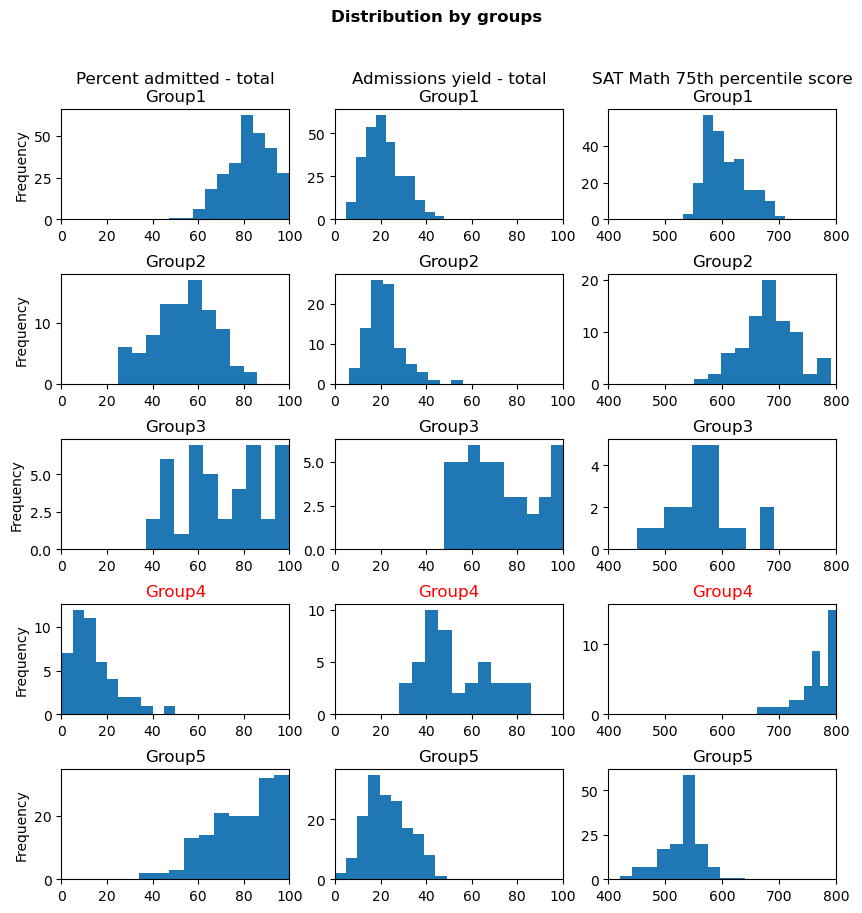

In [11]:
mycols2hist = ['Percent admitted - total (DRVADM2021)', 'Admissions yield - total (DRVADM2021)',
              'SAT Math 75th percentile score (ADM2015_RV)']
mycols_short = [re.sub('\(.*\)', '', s).strip() for s in mycols2hist]

nrows = K; ncols = len(mycols2hist)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10),sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.5)
data_merged.plot.hist(column=mycols2hist[0], by='Group', ax=axs[:,0], legend=None)
data_merged.plot.hist(column=mycols2hist[1], by='Group', ax=axs[:,1], legend=None)
data_merged.plot.hist(column=mycols2hist[2], by='Group', ax=axs[:,2], legend=None)
for i in range(nrows):
    for j in range(ncols):
        if i==0:
            axs[i,j].set_title(mycols_short[j] + '\n' + 'Group' + str(i+1))
        elif i == 3:
            axs[i,j].set_title('Group' + str(i+1), y=1, color='red')
        else:
            axs[i,j].set_title('Group' + str(i+1), y=1)
            
        if j > 0:
            axs[i,j].set_ylabel(None)
        if j == 2:
            axs[i,j].set_xlim([400,800])
        else:
            axs[i,j].set_xlim([0,100])
            
fig.suptitle('Distribution by groups', size=12, weight='bold')

plt.show()

### 4. Map localization

Finally, I localized the colleges on the map. Some useful information was viewable by hovering mouse for tooltips (currently with acceptance rate, yield rate, and faculty/student ratio) or clicking for popups (currently with website link). More types of useful information could be added in the future. On this map, the Ivy League members were labelled with purple star markers.

In [12]:
def map_colleges(data_show):

    mymap = folium.Map(location=[40, -100], tiles="OpenStreetMap", zoom_start=4)

    geom = geopandas.points_from_xy(data_show[['LONGITUDE']], 
                                    data_show[['LATITUDE']])
    mygeom = geopandas.GeoDataFrame(data_show, geometry=geom)
    mygeom.reset_index(inplace=True) # make sure: with continuous index

    nms = data_show['Name'].tolist()

    ivies = list(filter(lambda v: re.match('yale|brown|harvard|dartmouth|university of Pennsylvania|Columbia University|Cornell|Princeton', v, re.IGNORECASE), nms))
    mygeom['Ivy'] = 0
    mygeom.loc[mygeom['Name'].isin(ivies), 'Ivy'] = 1

    for myidx, myrow in mygeom.iterrows():
        mycoord = [myrow['geometry'].xy[1][0], myrow['geometry'].xy[0][0]]

        if myrow['Ivy'] == 1:
            type_color = "darkpurple"
            myicon = folium.Icon(icon='star', color=type_color, prefix='fa')
        else:
            type_color = "blue"
            myicon = folium.Icon(icon='university', color=type_color, prefix='fa')

        myweb = 'https://' + re.sub('.*www.', '', myrow['INSTURL'].strip('/')) 
        #must be in this format 'https://xxx.edu'

        mymap.add_child(
            folium.Marker(
                location=mycoord,
                popup = f'<a href="{myweb}"target="_blank">{myweb}</a>',
                tooltip = f"<strong>{str(myrow['Name'])}</strong> {myrow['CITY']} {myrow['STATE']}" + "<br>" +
                    "Acceptance Rate: " + str(myrow['Percent admitted - total (DRVADM2021)']) + "<br>" +
                    "Yield Rate: " + str(myrow['Admissions yield - total (DRVADM2021)']) + "<br>" +
                    "Student/Faculty: " + str(myrow['Student-to-faculty ratio (EF2020D)']),

                icon=myicon
            )
        )
        
    return (mymap)


__All colleges__

Note: There were errors in the data. <font color='blue'> For example, _Ana G. Mendez University_ in Florida was localized to \[18.388698, -66.061339\] in Puerto Rico according to the downloaded _Scorecard_ data mentioned above.</font>

In [13]:
map_all = map_colleges(data_merged)
map_all

__Selected colleges__

Only colleges from Group 4 were mapped for better view.


In [14]:
map_sel = map_colleges(data_merged[data_merged['Group'].isin([4])])
map_sel

### 5. Afterword

It is fun to see one's dream schools on map. Visualization is an important way to explore and interpret data. With complex and noisy data, it can help identify patterns and outliers, even errors, just as what I have observed on the map for _Ana G. Mendez University_.